In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import gc
import matplotlib.pyplot as plt
import zipfile

2025-02-09 18:13:02.932752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-09 18:13:02.932826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-09 18:13:02.934190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 18:13:02.942797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-02-09 18:13:03.749197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# y unchanged, half dset, 3d, 1stwala, outliers without

In [3]:
zip = './chessdata.zip'
dir = './datasets'

if not os.path.exists(dir):
    os.makedirs(dir)

with zipfile.ZipFile(zip, 'r') as zip_ref:
    files = zip_ref.namelist()

    for file in files:
        zip_ref.extract(file, dir)


In [40]:
csv1, csv2, csv3, csvtest = './datasets/Chess_1.csv', './datasets/Chess_2.csv', './datasets/Chess_3.csv', './datasets/test_track_8.csv'
df1, df2, df3, dftest = pd.read_csv(csv1), pd.read_csv(csv2), pd.read_csv(csv3), pd.read_csv(csvtest)

In [5]:
df = pd.concat([df1,df2,df3], axis = 0).reset_index(drop = True)

In [6]:
df.shape

(5941345, 2)

In [7]:
df = df.sample(frac=0.5, random_state=42)

In [8]:
df.shape

(2970672, 2)

In [9]:
from scipy.stats import zscore

df['Z_score'] = zscore(df['Evaluation'])
print("Data before removing outliers:", len(df))
df = df[(df['Z_score'] <= 3) & (df['Z_score'] >= -3)]
print("Data after removing outliers:", len(df))

Data before removing outliers: 2970672
Data after removing outliers: 2927425


In [10]:
# df

In [11]:
df = dftest

In [13]:
dftest

,ID
0,r3k2r/pp1qn1pp/2nbpp2/2pp4/5N2/4P3/PPPPQPPP/RN...
1,1Q6/2R5/4pk2/6q1/P7/1K6/8/7q b - - 0 42
2,r4rk1/pp1b1qpp/3Pp2n/2B1p3/8/P5NP/1P2QPP1/2R1K...
3,8/8/4k3/pKp2r2/2P5/8/8/8 b - - 3 53
4,q3kbnr/1b1p1ppp/4p3/1p2n3/2p1P3/2PP4/1P2QPPP/1...
...,...
1979378,rnb1k2r/ppq2pbp/2p2np1/3pB3/1P6/P3PN2/2PP1PPP/...
1979379,rnbqk2r/ppp1bp1p/4pnp1/8/5B2/2NP1N2/PPP1BPPP/R...
1979380,1r2r1k1/p1p2pp1/3p3p/N1pPp3/P1P1Pb2/8/P4PPP/R3...
1979381,r1bQ1nkr/pp3ppp/5n2/3q4/8/3P2PN/P1P1PR1P/1N4K1...


In [14]:
fen_cols = ['FEN_board', 'next', 'CA', '_', 'hm', 'fm']
df[fen_cols] = df['ID'].str.split(' ', expand=True)
df.drop(['_', 'ID'], axis=1, inplace=True)


df['next'] = df['next'].map({'b': -1, 'w': 1}).astype(np.int8)


castlingdict = {'K': 'CA_K', 'Q': 'CA_Q', 'k': 'CA_k', 'q': 'CA_q'}
for char, col in castlingdict.items():
    df[col] = df['CA'].str.contains(char).astype(np.int8)
df.drop('CA', axis=1, inplace=True)


df['hm'] = df['hm'].astype(np.int64)
df['fm'] = df['fm'].astype(np.int64)




def numbw(fen_str):
    blk= {
      'p': 0,  
      'r': 0,  
      'n': 0,  
      'b': 0,  
      'q': 0,  
      'k': 0,  
    }
    wht = {
      'P': 0,  
      'R': 0,  
      'N': 0,  
      'B': 0,  
      'Q': 0,  
      'K': 0,  
    }
    for c in fen_str:
        if c.islower():  
            blk[c] = blk.get(c, 0) + 1
        elif c.isupper():  
            wht[c] = wht.get(c, 0) + 1

    return blk, wht

df[['numb', 'numw']] = pd.DataFrame(df['FEN_board'].apply(numbw).tolist())

tonum3d = {
    'r': -np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'n': -np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'b': -np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'q': -np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'k': -np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'p': -np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),

    'R': np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'N': np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'B': np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'Q': np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'K': np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'P': np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),
}


def fen2cube(fen, tonum3d):
    board = np.zeros((8, 8, 8), dtype=np.float32)
    for i, row in enumerate(fen.split('/')):
        j = 0
        for c in row:
            if c.isdigit():
                j += int(c)
            else:
                board[i, j] = tonum3d[c]
                j += 1
    return board

df['cube1'] = df['FEN_board'].apply(lambda x: fen2cube(x, tonum3d))
cubestacked1 = np.stack(df['cube1'].values)

In [15]:
df

,FEN_board,next,hm,fm,CA_K,CA_Q,CA_k,CA_q,numb,numw,cube1
0,r3k2r/pp1qn1pp/2nbpp2/2pp4/5N2/4P3/PPPPQPPP/RN...,1,10,14,0,0,1,1,"{'p': 8, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 1, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."
1,1Q6/2R5/4pk2/6q1/P7/1K6/8/7q,-1,0,42,0,0,0,0,"{'p': 1, 'r': 0, 'n': 0, 'b': 0, 'q': 2, 'k': 1}","{'P': 1, 'R': 1, 'N': 0, 'B': 0, 'Q': 1, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [8..."
2,r4rk1/pp1b1qpp/3Pp2n/2B1p3/8/P5NP/1P2QPP1/2R1KB1R,-1,8,19,1,0,0,0,"{'p': 6, 'r': 2, 'n': 1, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 2, 'N': 1, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."
3,8/8/4k3/pKp2r2/2P5/8/8/8,-1,3,53,0,0,0,0,"{'p': 2, 'r': 1, 'n': 0, 'b': 0, 'q': 0, 'k': 1}","{'P': 1, 'R': 0, 'N': 0, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
4,q3kbnr/1b1p1ppp/4p3/1p2n3/2p1P3/2PP4/1P2QPPP/1...,1,1,11,1,0,1,0,"{'p': 7, 'r': 1, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 1, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -..."
...,...,...,...,...,...,...,...,...,...,...,...
1979378,rnb1k2r/ppq2pbp/2p2np1/3pB3/1P6/P3PN2/2PP1PPP/...,-1,4,8,1,1,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."
1979379,rnbqk2r/ppp1bp1p/4pnp1/8/5B2/2NP1N2/PPP1BPPP/R...,-1,1,8,0,0,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."
1979380,1r2r1k1/p1p2pp1/3p3p/N1pPp3/P1P1Pb2/8/P4PPP/R3...,1,0,24,0,0,0,0,"{'p': 8, 'r': 2, 'n': 0, 'b': 1, 'q': 0, 'k': 1}","{'P': 8, 'R': 2, 'N': 1, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-..."
1979381,r1bQ1nkr/pp3ppp/5n2/3q4/8/3P2PN/P1P1PR1P/1N4K1,1,0,16,0,0,0,0,"{'p': 5, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 1, 'N': 2, 'B': 0, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."


In [14]:
12

12

In [18]:
df

,FEN_board,next,hm,fm,CA_K,CA_Q,CA_k,CA_q,numb,numw,cube1
0,r3k2r/pp1qn1pp/2nbpp2/2pp4/5N2/4P3/PPPPQPPP/RN...,1,10,14,0,0,1,1,"{'p': 8, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 1, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."
1,1Q6/2R5/4pk2/6q1/P7/1K6/8/7q,-1,0,42,0,0,0,0,"{'p': 1, 'r': 0, 'n': 0, 'b': 0, 'q': 2, 'k': 1}","{'P': 1, 'R': 1, 'N': 0, 'B': 0, 'Q': 1, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [8..."
2,r4rk1/pp1b1qpp/3Pp2n/2B1p3/8/P5NP/1P2QPP1/2R1KB1R,-1,8,19,1,0,0,0,"{'p': 6, 'r': 2, 'n': 1, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 2, 'N': 1, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."
3,8/8/4k3/pKp2r2/2P5/8/8/8,-1,3,53,0,0,0,0,"{'p': 2, 'r': 1, 'n': 0, 'b': 0, 'q': 0, 'k': 1}","{'P': 1, 'R': 0, 'N': 0, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
4,q3kbnr/1b1p1ppp/4p3/1p2n3/2p1P3/2PP4/1P2QPPP/1...,1,1,11,1,0,1,0,"{'p': 7, 'r': 1, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 1, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -..."
...,...,...,...,...,...,...,...,...,...,...,...
1979378,rnb1k2r/ppq2pbp/2p2np1/3pB3/1P6/P3PN2/2PP1PPP/...,-1,4,8,1,1,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."
1979379,rnbqk2r/ppp1bp1p/4pnp1/8/5B2/2NP1N2/PPP1BPPP/R...,-1,1,8,0,0,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."
1979380,1r2r1k1/p1p2pp1/3p3p/N1pPp3/P1P1Pb2/8/P4PPP/R3...,1,0,24,0,0,0,0,"{'p': 8, 'r': 2, 'n': 0, 'b': 1, 'q': 0, 'k': 1}","{'P': 8, 'R': 2, 'N': 1, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-..."
1979381,r1bQ1nkr/pp3ppp/5n2/3q4/8/3P2PN/P1P1PR1P/1N4K1,1,0,16,0,0,0,0,"{'p': 5, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 1, 'N': 2, 'B': 0, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -..."


In [16]:
df = df.dropna()

In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression

black_pieces = pd.json_normalize(df['numb'])
white_pieces = pd.json_normalize(df['numw'])

X = pd.concat([black_pieces, white_pieces], axis=1)
y = df['Evaluation']

model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [18]:
del zip

In [19]:
black_weights = dict(zip(black_pieces.columns, model.coef_[:6]))
white_weights = dict(zip(white_pieces.columns, model.coef_[6:]))

In [19]:
white_weights ={'P': 0.55766841775115,
 'R': -0.22384384406494998,
 'N': -0.6152549360423548,
 'B': -0.6641308111861762,
 'Q': -1.9615679236600596,
 'K': 0.0}

In [20]:
black_weights ={'p': 0.04473323407809408,
 'r': 0.07230358408945219,
 'n': -0.057320978614105775,
 'b': 0.13213246344153942,
 'q': 0.7980719034607346,
 'k': -6.661338147750939e-16}

In [21]:
def weighted_sum(piece_counts, piece_weights):
    weighted_sum = 0
    for piece, count in piece_counts.items():
        weight = piece_weights.get(piece, 0)
        weighted_sum += count * weight
    return weighted_sum

df['wtdb'] = df['numb'].apply(lambda blk: weighted_sum(blk, black_weights))
df['wtdw'] = df['numw'].apply(lambda wht: weighted_sum(wht, white_weights))


In [22]:
df

,FEN_board,next,hm,fm,CA_K,CA_Q,CA_k,CA_q,numb,numw,cube1,wtdb,wtdw
0,r3k2r/pp1qn1pp/2nbpp2/2pp4/5N2/4P3/PPPPQPPP/RN...,1,10,14,0,0,1,1,"{'p': 8, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 1, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.318035,0.157451
1,1Q6/2R5/4pk2/6q1/P7/1K6/8/7q,-1,0,42,0,0,0,0,"{'p': 1, 'r': 0, 'n': 0, 'b': 0, 'q': 2, 'k': 1}","{'P': 1, 'R': 1, 'N': 0, 'B': 0, 'Q': 1, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [8...",1.640877,-1.627743
2,r4rk1/pp1b1qpp/3Pp2n/2B1p3/8/P5NP/1P2QPP1/2R1KB1R,-1,8,19,1,0,0,0,"{'p': 6, 'r': 2, 'n': 1, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 2, 'N': 1, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.285890,-1.006762
3,8/8/4k3/pKp2r2/2P5/8/8/8,-1,3,53,0,0,0,0,"{'p': 2, 'r': 1, 'n': 0, 'b': 0, 'q': 0, 'k': 1}","{'P': 1, 'R': 0, 'N': 0, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...",0.161770,0.557668
4,q3kbnr/1b1p1ppp/4p3/1p2n3/2p1P3/2PP4/1P2QPPP/1...,1,1,11,1,0,1,0,"{'p': 7, 'r': 1, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 1, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -...",1.333131,-0.840504
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979378,rnb1k2r/ppq2pbp/2p2np1/3pB3/1P6/P3PN2/2PP1PPP/...,-1,4,8,1,1,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.405435,-0.506680
1979379,rnbqk2r/ppp1bp1p/4pnp1/8/5B2/2NP1N2/PPP1BPPP/R...,-1,1,8,0,0,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.405435,-1.064348
1979380,1r2r1k1/p1p2pp1/3p3p/N1pPp3/P1P1Pb2/8/P4PPP/R3...,1,0,24,0,0,0,0,"{'p': 8, 'r': 2, 'n': 0, 'b': 1, 'q': 0, 'k': 1}","{'P': 8, 'R': 2, 'N': 1, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-...",0.634606,3.398405
1979381,r1bQ1nkr/pp3ppp/5n2/3q4/8/3P2PN/P1P1PR1P/1N4K1,1,0,16,0,0,0,0,"{'p': 5, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 1, 'N': 2, 'B': 0, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.183836,-0.069911


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def makemodel3d():
    cube_input = Input(shape=(8, 8, 8), name='image_input')

    casting = layers.Conv2D(16, (3, 3), activation=None, padding='same')(cube_input)
    casting = layers.BatchNormalization()(casting)

    x = layers.Conv2D(16, (3, 3), activation=None, padding='same')(casting)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (2, 2), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    vector_input1 = Input(shape=(4,), name='vector_input1')
    y1 = layers.Dense(16, activation='relu')(vector_input1)
    y1 = layers.Dense(32, activation='relu')(y1)

    vector_input2 = Input(shape=(3,), name='vector_input2')
    y2 = layers.Dense(16, activation='relu')(vector_input2)
    y2 = layers.Dense(32, activation='relu')(y2)

    vector_input3 = Input(shape=(2,), name='vector_input3')
    y3 = layers.Dense(16, activation='relu')(vector_input3)
    y3 = layers.Dense(32, activation='relu')(y3)

    combined = layers.Concatenate()([x, y1, y2, y3])

    z = layers.Dense(128, activation=None)(combined)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(64, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dropout(0.5)(z)

    z = layers.Dense(32, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(16, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(4, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    output = layers.Dense(1, activation='linear', name='output')(z)

    model = Model(inputs=[cube_input, vector_input1, vector_input2, vector_input3], outputs=output)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-2,
        weight_decay=1e-3
    )

    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    return model


In [24]:
vecinp1 = df[['CA_K', 'CA_Q', 'CA_k', 'CA_q']].to_numpy()
vecinp2 = df[['hm', 'fm', 'next']].astype(np.float32).to_numpy()
vecinp3 = df[['wtdb', 'wtdw']].astype(np.float32).to_numpy()
# y = df['Evaluation'].values

In [25]:
cubestacked1 = np.stack(df['cube1'].values)

In [29]:
# (cubetr, cubeval,
#  vec1tr, vec1val,
#  vec2tr, vec2val,
#  vec3tr, vec3val,
#  ytr3d, yval3d) = train_test_split(
#     cubestacked1, vecinp1, vecinp2, vecinp3, y,
#     test_size=0.2,
#     random_state=42
# )


In [30]:
xtest = [cubestacked1, vecinp1, vecinp2, vecinp3]

In [28]:
xtr1_3d = [cubetr, vec1tr, vec2tr, vec3tr]
xval1_3d = [cubeval, vec1val, vec2val, vec3val]




NameError: name 'cubetr' is not defined

In [35]:
model3d = makemodel3d()

2025-02-09 17:23:39.148686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [1]:
12

12

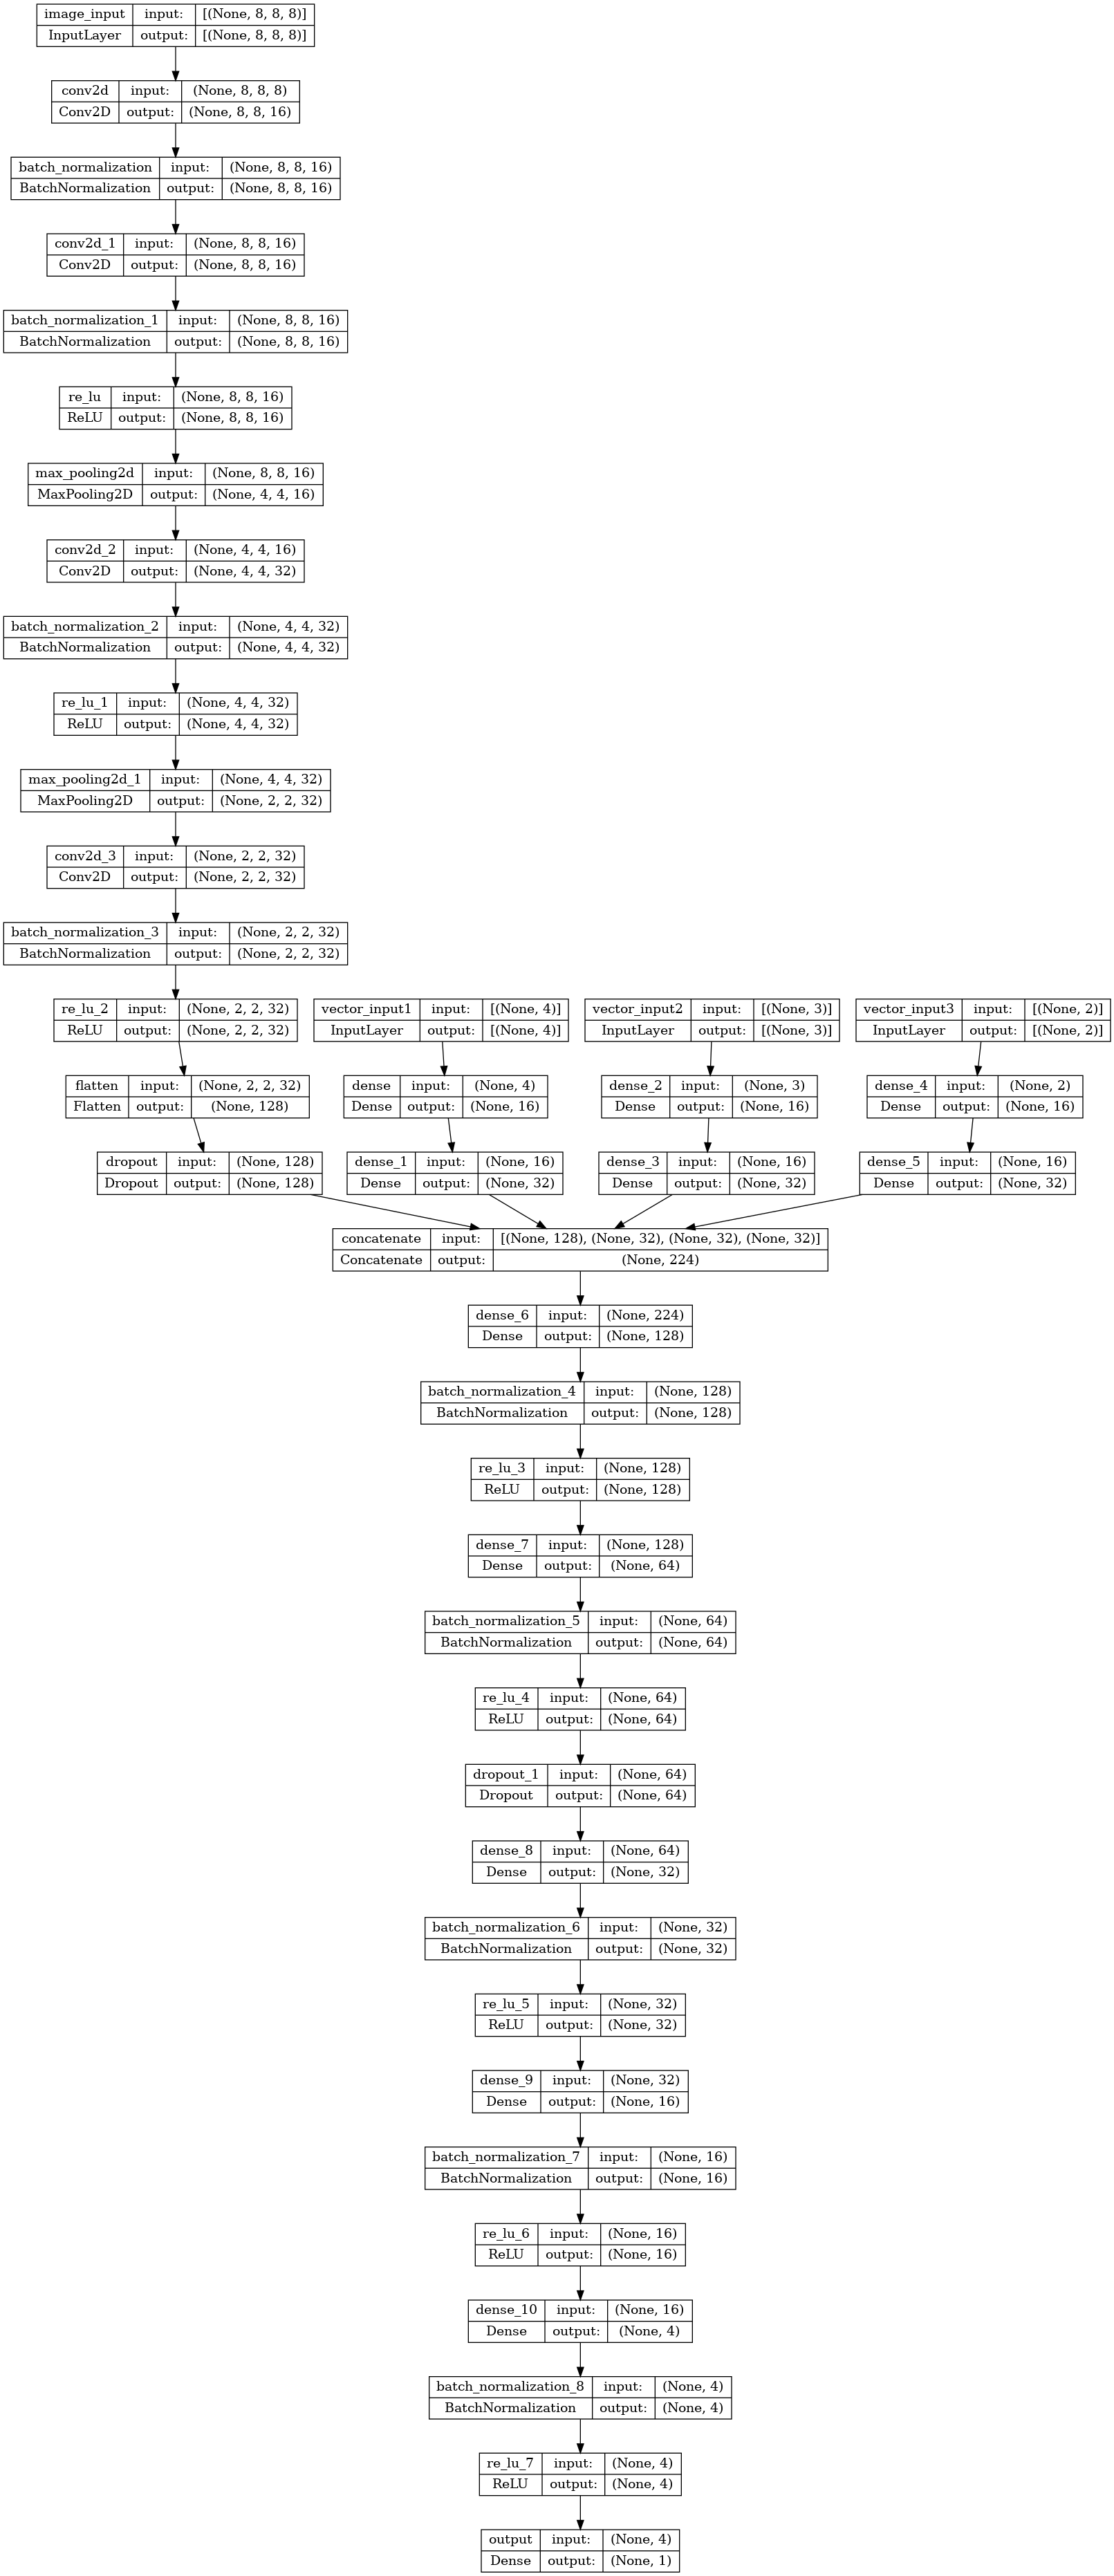

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(model3d, to_file='model_base.png', show_shapes=True, show_layer_names=True)

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

model3d = load_model("best_model_3d.h5")



2025-02-09 18:15:58.895650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath="best_model_3d.h5",  
    monitor="val_loss",  
    save_best_only=True,  
    save_weights_only=False,  
    mode="min",  
    verbose=1  
)

history3d = model3d.fit(
    xtr1_3d,
    ytr3d,
    validation_data=(xval1_3d, yval3d),
    epochs=150,
    batch_size=16384,
    callbacks=[checkpoint_cb]  
)


In [32]:
yvalpred = (model3d.predict(xtest))

2025-02-09 18:16:10.454199: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


61856/61856 [==============================] - 96s 2ms/step


In [34]:
df

,FEN_board,next,hm,fm,CA_K,CA_Q,CA_k,CA_q,numb,numw,cube1,wtdb,wtdw,Predictions
0,r3k2r/pp1qn1pp/2nbpp2/2pp4/5N2/4P3/PPPPQPPP/RN...,1,10,14,0,0,1,1,"{'p': 8, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 1, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.318035,0.157451,-105.405228
1,1Q6/2R5/4pk2/6q1/P7/1K6/8/7q,-1,0,42,0,0,0,0,"{'p': 1, 'r': 0, 'n': 0, 'b': 0, 'q': 2, 'k': 1}","{'P': 1, 'R': 1, 'N': 0, 'B': 0, 'Q': 1, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [8...",1.640877,-1.627743,-401.226013
2,r4rk1/pp1b1qpp/3Pp2n/2B1p3/8/P5NP/1P2QPP1/2R1KB1R,-1,8,19,1,0,0,0,"{'p': 6, 'r': 2, 'n': 1, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 2, 'N': 1, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.285890,-1.006762,223.633789
3,8/8/4k3/pKp2r2/2P5/8/8/8,-1,3,53,0,0,0,0,"{'p': 2, 'r': 1, 'n': 0, 'b': 0, 'q': 0, 'k': 1}","{'P': 1, 'R': 0, 'N': 0, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...",0.161770,0.557668,-558.618469
4,q3kbnr/1b1p1ppp/4p3/1p2n3/2p1P3/2PP4/1P2QPPP/1...,1,1,11,1,0,1,0,"{'p': 7, 'r': 1, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 1, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -...",1.333131,-0.840504,-77.455498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979378,rnb1k2r/ppq2pbp/2p2np1/3pB3/1P6/P3PN2/2PP1PPP/...,-1,4,8,1,1,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.405435,-0.506680,32.868042
1979379,rnbqk2r/ppp1bp1p/4pnp1/8/5B2/2NP1N2/PPP1BPPP/R...,-1,1,8,0,0,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.405435,-1.064348,70.945679
1979380,1r2r1k1/p1p2pp1/3p3p/N1pPp3/P1P1Pb2/8/P4PPP/R3...,1,0,24,0,0,0,0,"{'p': 8, 'r': 2, 'n': 0, 'b': 1, 'q': 0, 'k': 1}","{'P': 8, 'R': 2, 'N': 1, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-...",0.634606,3.398405,10.888885
1979381,r1bQ1nkr/pp3ppp/5n2/3q4/8/3P2PN/P1P1PR1P/1N4K1,1,0,16,0,0,0,0,"{'p': 5, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 1, 'N': 2, 'B': 0, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.183836,-0.069911,-314.689636


In [51]:
df['Predictions'] = yvalpred

In [42]:
df.columns

Index(['FEN_board', 'next', 'hm', 'fm', 'CA_K', 'CA_Q', 'CA_k', 'CA_q', 'numb',
       'numw', 'cube1', 'wtdb', 'wtdw', 'Predictions', 'ID'],
      dtype='object')

In [41]:
df['ID'] = dftest['ID']

In [45]:
df

,FEN_board,next,hm,fm,CA_K,CA_Q,CA_k,CA_q,numb,numw,cube1,wtdb,wtdw,Predictions,ID
0,r3k2r/pp1qn1pp/2nbpp2/2pp4/5N2/4P3/PPPPQPPP/RN...,1,10,14,0,0,1,1,"{'p': 8, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 1, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.318035,0.157451,-105.405228,r3k2r/pp1qn1pp/2nbpp2/2pp4/5N2/4P3/PPPPQPPP/RN...
1,1Q6/2R5/4pk2/6q1/P7/1K6/8/7q,-1,0,42,0,0,0,0,"{'p': 1, 'r': 0, 'n': 0, 'b': 0, 'q': 2, 'k': 1}","{'P': 1, 'R': 1, 'N': 0, 'B': 0, 'Q': 1, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [8...",1.640877,-1.627743,-401.226013,1Q6/2R5/4pk2/6q1/P7/1K6/8/7q b - - 0 42
2,r4rk1/pp1b1qpp/3Pp2n/2B1p3/8/P5NP/1P2QPP1/2R1KB1R,-1,8,19,1,0,0,0,"{'p': 6, 'r': 2, 'n': 1, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 2, 'N': 1, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.285890,-1.006762,223.633789,r4rk1/pp1b1qpp/3Pp2n/2B1p3/8/P5NP/1P2QPP1/2R1K...
3,8/8/4k3/pKp2r2/2P5/8/8/8,-1,3,53,0,0,0,0,"{'p': 2, 'r': 1, 'n': 0, 'b': 0, 'q': 0, 'k': 1}","{'P': 1, 'R': 0, 'N': 0, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...",0.161770,0.557668,-558.618469,8/8/4k3/pKp2r2/2P5/8/8/8 b - - 3 53
4,q3kbnr/1b1p1ppp/4p3/1p2n3/2p1P3/2PP4/1P2QPPP/1...,1,1,11,1,0,1,0,"{'p': 7, 'r': 1, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 1, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -...",1.333131,-0.840504,-77.455498,q3kbnr/1b1p1ppp/4p3/1p2n3/2p1P3/2PP4/1P2QPPP/1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979378,rnb1k2r/ppq2pbp/2p2np1/3pB3/1P6/P3PN2/2PP1PPP/...,-1,4,8,1,1,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.405435,-0.506680,32.868042,rnb1k2r/ppq2pbp/2p2np1/3pB3/1P6/P3PN2/2PP1PPP/...
1979379,rnbqk2r/ppp1bp1p/4pnp1/8/5B2/2NP1N2/PPP1BPPP/R...,-1,1,8,0,0,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.405435,-1.064348,70.945679,rnbqk2r/ppp1bp1p/4pnp1/8/5B2/2NP1N2/PPP1BPPP/R...
1979380,1r2r1k1/p1p2pp1/3p3p/N1pPp3/P1P1Pb2/8/P4PPP/R3...,1,0,24,0,0,0,0,"{'p': 8, 'r': 2, 'n': 0, 'b': 1, 'q': 0, 'k': 1}","{'P': 8, 'R': 2, 'N': 1, 'B': 0, 'Q': 0, 'K': 1}","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-...",0.634606,3.398405,10.888885,1r2r1k1/p1p2pp1/3p3p/N1pPp3/P1P1Pb2/8/P4PPP/R3...
1979381,r1bQ1nkr/pp3ppp/5n2/3q4/8/3P2PN/P1P1PR1P/1N4K1,1,0,16,0,0,0,0,"{'p': 5, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}","{'P': 6, 'R': 1, 'N': 2, 'B': 0, 'Q': 1, 'K': 1}","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...",1.183836,-0.069911,-314.689636,r1bQ1nkr/pp3ppp/5n2/3q4/8/3P2PN/P1P1PR1P/1N4K1...


In [48]:
df = df.drop(columns=['FEN_board', 'next', 'hm', 'fm', 'CA_K', 'CA_Q', 'CA_k', 'CA_q', 'numb', 'numw', 'cube1', 'wtdb', 'wtdw', 'Predictions'])


In [52]:
df

,ID,Predictions
0,r3k2r/pp1qn1pp/2nbpp2/2pp4/5N2/4P3/PPPPQPPP/RN...,-105.405228
1,1Q6/2R5/4pk2/6q1/P7/1K6/8/7q b - - 0 42,-401.226013
2,r4rk1/pp1b1qpp/3Pp2n/2B1p3/8/P5NP/1P2QPP1/2R1K...,223.633789
3,8/8/4k3/pKp2r2/2P5/8/8/8 b - - 3 53,-558.618469
4,q3kbnr/1b1p1ppp/4p3/1p2n3/2p1P3/2PP4/1P2QPPP/1...,-77.455498
...,...,...
1979378,rnb1k2r/ppq2pbp/2p2np1/3pB3/1P6/P3PN2/2PP1PPP/...,32.868042
1979379,rnbqk2r/ppp1bp1p/4pnp1/8/5B2/2NP1N2/PPP1BPPP/R...,70.945679
1979380,1r2r1k1/p1p2pp1/3p3p/N1pPp3/P1P1Pb2/8/P4PPP/R3...,10.888885
1979381,r1bQ1nkr/pp3ppp/5n2/3q4/8/3P2PN/P1P1PR1P/1N4K1...,-314.689636


In [53]:
df.to_csv("final.csv")

In [54]:
len(df)

1979383

(array([7.00000e+00, 1.19000e+02, 6.83500e+03, 1.45600e+03, 2.06108e+05,
        9.57976e+05, 8.32100e+03, 5.96000e+03, 1.44600e+03, 4.10000e+01]),
 array([-7812. , -6314.7, -4817.4, -3320.1, -1822.8,  -325.5,  1171.8,
         2669.1,  4166.4,  5663.7,  7161. ]),
 <BarContainer object of 10 artists>)

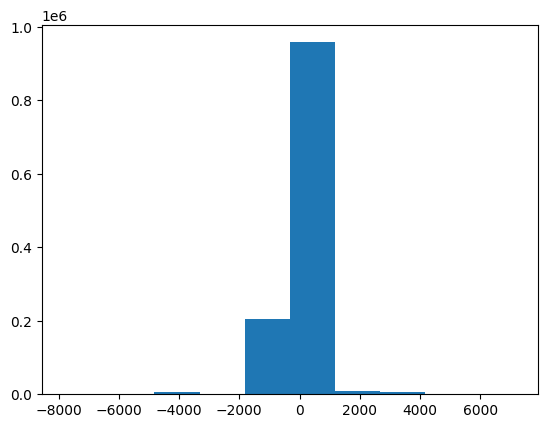

In [39]:
plt.hist(yval3d)

(array([3.30000e+01, 5.55200e+03, 6.13000e+02, 2.87000e+02, 2.75932e+05,
        8.99160e+05, 6.48000e+02, 4.13000e+02, 5.55500e+03, 7.60000e+01]),
 array([-5087.54736328, -4087.33984375, -3087.13232422, -2086.92456055,
        -1086.71704102,   -86.50952148,   913.69805908,  1913.90563965,
         2914.11328125,  3914.32080078,  4914.52832031]),
 <BarContainer object of 10 artists>)

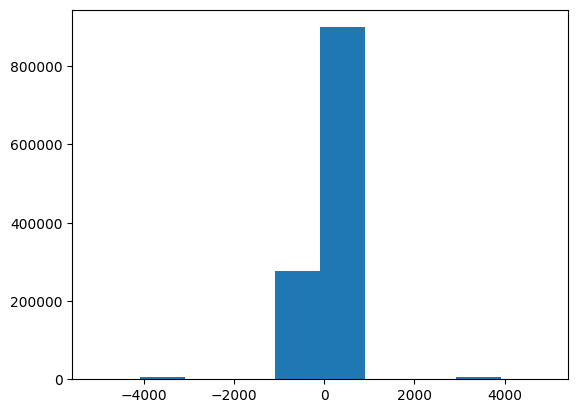

In [38]:
plt.hist(yvalpred)

In [ ]:
model.predict()